<a href="https://colab.research.google.com/github/Untick/Usedesk/blob/main/Lapkov%20Anatoly/a_lapkov_usedesk_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [3]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

from IPython.display import display

%matplotlib inline

In [4]:
def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value
  return None

def save_response_content(response, destination):
  CHUNK_SIZE = 32768
  with open(destination, 'wb') as f:
    for chunk in response.iter_content(CHUNK_SIZE):
      if chunk:
        f.write(chunk)

def download_file_from_google_drive(id, destination):
  URL = 'https://docs.google.com/uc?export=download'
  session = requests.Session()
  response = session.get(URL, params = { 'id' : id }, stream = True)
  token = get_confirm_token(response)
  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)
  save_response_content(response, destination)    


In [5]:
FILE_1_ID = '1PwMWQUCETRusiWN9hep2-12GWkdBrpkR'
FILE_1_NAME = 'file_1.xlsx'
FILE_2_ID = '1cCjgzBbSsBnzEfRQ9NgIv_ZVjmRywoqV'
FILE_2_NAME = 'file_2.xlsx'
FILES = {
    FILE_1_ID: FILE_1_NAME,
    FILE_2_ID: FILE_2_NAME
}

In [6]:
for id in FILES:
    if not os.path.exists(FILES[id]):
        download_file_from_google_drive(id, FILES[id])

In [7]:
file_1_data = pd.read_excel(FILE_1_NAME)
file_1_data.drop(columns = [file_1_data.columns[0], file_1_data.columns[1]], axis = 1, inplace = True)
file_2_data, file_2_links = pd.read_excel(FILE_2_NAME, sheet_name = [0, 2]).values()
file_2_data.drop(columns = file_2_data.columns[0], axis = 1, inplace = True)

In [11]:
corr_wodate_abs = file_2_data.drop('дата', axis = 1).corr().abs()
corr_high = corr_wodate_abs[(corr_wodate_abs['рейтинг'] < 1.) & (corr_wodate_abs['рейтинг'] >= 0.06)]
# display(corr_wodate_abs.sort_values('рейтинг', ascending = False).head(10))
corr_cols = corr_high.index.to_list()
# display(corr_cols)
# display(len(corr_cols))
corr_data = file_2_data[corr_cols]
display(corr_data.head(20))


,всего,есть ответ,закрыт,nps,email,usedesk_chat,telegram,whatsapp,fb_instagram,question,medium,правила_dist,licens,бз,бз_ст
0,3709,3442,2466,1231,1317,779,737,778,70,3376,2568,66,13,1,4
1,5573,5301,4715,2004,2008,1248,1125,1089,66,5107,3735,62,13,1,4
2,6138,5983,5496,2242,1991,1440,1222,1378,78,5611,4114,64,13,1,4
3,7834,7664,7094,2851,2519,1856,1559,1765,106,7191,5313,62,13,1,4
4,7344,7252,6657,2686,2377,1764,1552,1596,25,6724,4894,60,13,1,4
5,9389,9321,8579,3441,3182,2002,1813,2206,152,8469,6416,63,13,1,4
6,9709,9572,8870,3975,3300,2330,1701,2298,42,8722,6314,64,13,1,4
7,6497,6390,5933,2604,2307,1657,1125,1307,68,5928,4233,61,13,1,4
8,5139,5049,4750,2017,1756,1258,911,1141,50,4712,3408,63,13,1,4
9,5092,4991,4623,2008,1915,1293,744,1045,61,4617,3259,63,13,1,4


In [12]:
scalers = {}
x_data_scaled = pd.DataFrame(columns = corr_cols)
hs = []
for col in corr_cols:
    a = file_2_data[col].to_numpy().reshape(-1, 1)
    scalers[col] = MinMaxScaler()
    scalers[col].fit(a)
    hs.append(scalers[col].transform(a))
x_data = np.hstack(hs)

x_data.shape

(11779, 15)

In [14]:
df = pd.DataFrame(x_data)
for i in range(4):
    print(len(df[file_2_data['рейтинг'] == i]))

2367
3758
3486
2168


In [15]:
CLASSES_CNT = len(file_2_data['рейтинг'].unique())
y_data = utils.to_categorical(file_2_data['рейтинг'], CLASSES_CNT)
# display(CLASSES_CNT)
# display(y_data[:20])

In [16]:
x_train, x_valid_test, y_train, y_valid_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)
x_test, x_valid, y_test, y_valid = train_test_split(x_valid_test, y_valid_test, test_size = 0.5, random_state = 42)

In [17]:
model = Sequential()
model.add(Input(shape = (corr_data.shape[1])))
# model.add(BatchNormalization())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(y_data.shape[1], activation = 'softmax'))

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.00001), metrics = ['accuracy'])

In [19]:
history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs = 10, verbose = 1)

Epoch 1/10
295/295 [==============================] - 11s 32ms/step - loss: 1.3851 - accuracy: 0.3048 - val_loss: 1.3833 - val_accuracy: 0.3192
Epoch 2/10
295/295 [==============================] - 10s 33ms/step - loss: 1.3816 - accuracy: 0.3204 - val_loss: 1.3803 - val_accuracy: 0.3285
Epoch 3/10
295/295 [==============================] - 9s 31ms/step - loss: 1.3773 - accuracy: 0.3322 - val_loss: 1.3777 - val_accuracy: 0.3268
Epoch 4/10
295/295 [==============================] - 9s 32ms/step - loss: 1.3755 - accuracy: 0.3311 - val_loss: 1.3752 - val_accuracy: 0.3234
Epoch 5/10
295/295 [==============================] - 10s 33ms/step - loss: 1.3737 - accuracy: 0.3287 - val_loss: 1.3729 - val_accuracy: 0.3251
Epoch 6/10
295/295 [==============================] - 9s 32ms/step - loss: 1.3702 - accuracy: 0.3339 - val_loss: 1.3708 - val_accuracy: 0.3234
Epoch 7/10
295/295 [==============================] - 9s 32ms/step - loss: 1.3692 - accuracy: 0.3356 - val_loss: 1.3688 - val_accuracy: 0.3

In [20]:
y_pred = model.predict(x_test)

37/37 [==============================] - 0s 4ms/step


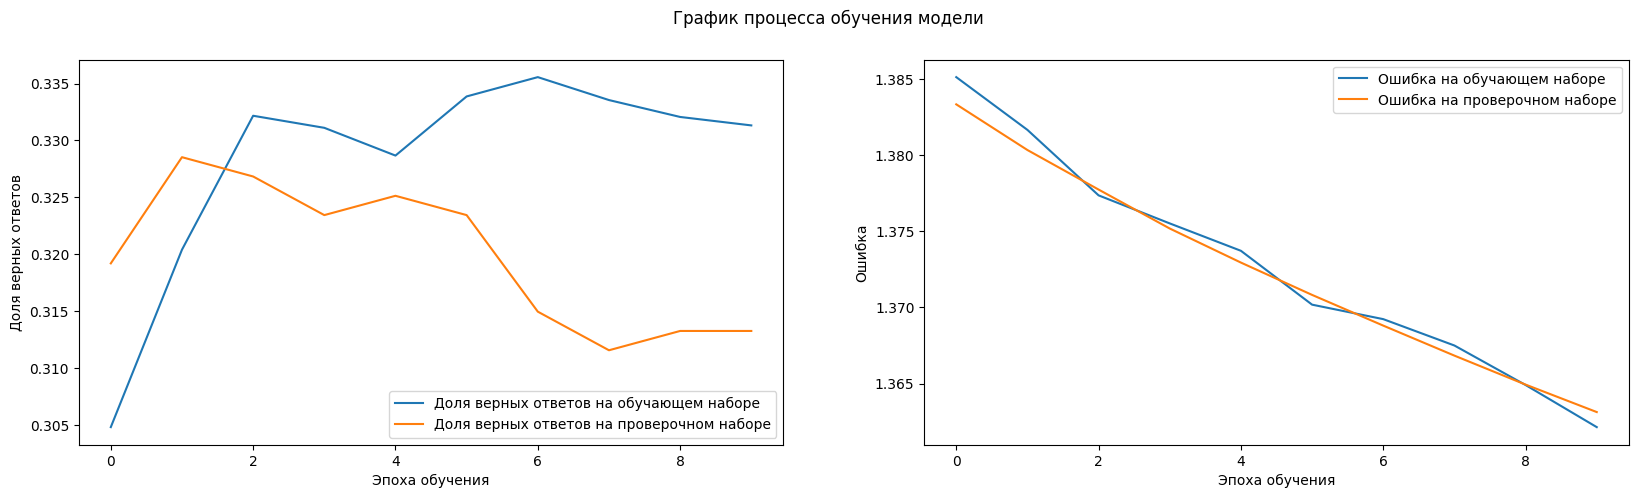

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'], label = 'Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'], label = 'Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer = True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'], label = 'Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'], label = 'Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer = True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()

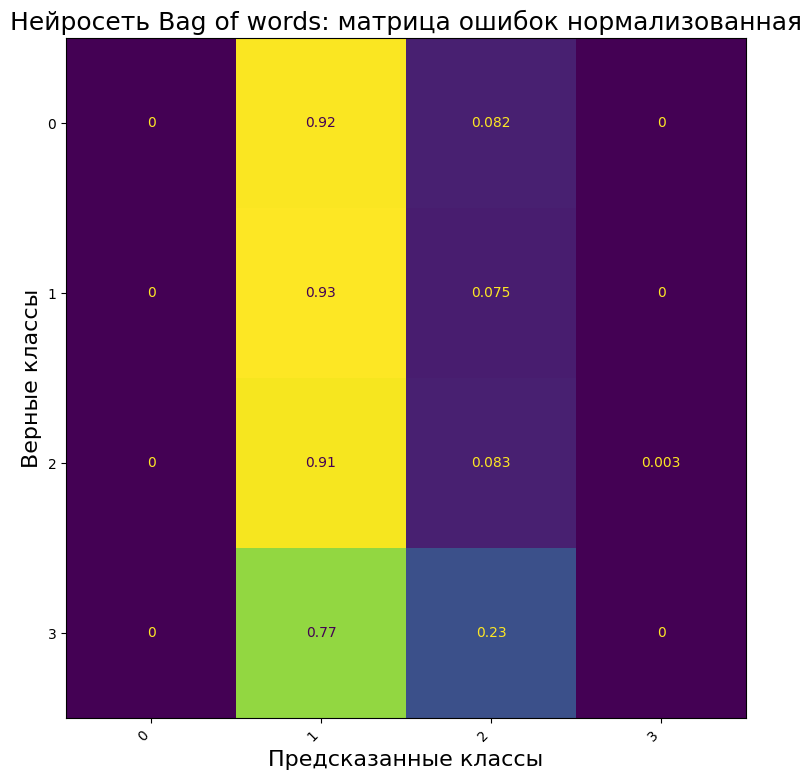

----------------------------------------------------------------------------------------------------
Нейросеть: Bag of words
Класс: "0"                   92% сеть отнесла к классу: "0"                  - НЕВЕРНО :-(
Класс: "1"                   92% сеть отнесла к классу: "1"                  - ВЕРНО :-)
Класс: "2"                   91% сеть отнесла к классу: "2"                  - НЕВЕРНО :-(
Класс: "3"                   77% сеть отнесла к классу: "3"                  - НЕВЕРНО :-(

Средняя точность распознавания:  25%


In [22]:
title = 'UseDesk, классификация'
class_labels = [0, 1, 2, 3]
cm = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1), normalize = 'true')
cm = np.around(cm, 3)
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize = 18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_labels)
disp.plot(ax = ax)
plt.gca().images[-1].colorbar.remove()
plt.xlabel('Предсказанные классы', fontsize = 16)
plt.ylabel('Верные классы', fontsize = 16)
fig.autofmt_xdate(rotation = 45)
plt.show()    

print('-' * 100)
print(f'Нейросеть: {title}')

for cls in range(len(class_labels)):
    cls_pred = np.argmax(cm[cls])
    msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
    label = f'"{class_labels[cls]}"'
    predict = 100. * cm[cls, cls_pred]
    print(f'Класс: {label:<20} {predict:3.0f}% сеть отнесла к классу: {label:<20} - {msg}')

print(f'\nСредняя точность распознавания: {100. * cm.diagonal().mean():3.0f}%')